# Run BEHAV3D feature extraction and T cell analysis

This notebook runs the feature extraction and behavioral analysis pipeline of BEHAV3D

To work correctly, it requires the following input:
- A metadata ***.csv*** containing information on every sample to be processed
- A 4D (tzyx) ***.tiff*** file of the ***T-cell*** segments tracked over time (Segment IDs in multiple timepoints should match)
- A 4D (tzyx) ***.tiff*** file of the ***Organoid*** segments tracked over time (Segment IDs in multiple timepoints should match)

In [1]:
from behav3d.analysis.feature_extraction import (
    calculate_track_features,
    filter_tracks,
    summarize_track_features
)
from behav3d.analysis.tcell_analysis import run_tcell_analysis
from behav3d.analysis.backprojection import backproject_behav3d, save_backprojection

import pandas as pd
from pathlib import Path

%matplotlib inline

/Users/samdeblank/opt/anaconda3/envs/BEHAV3D/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<Figure size 100x100 with 0 Axes>

### Set BEHAV3D parameters

***NOTE*** 

Dynamic Time Warping seems to work best if all tracks are of equal length. To get tracks to equal length, set both ***tcell_min_track_length*** and ***tcell_max_track_length*** to the same value

In [2]:
### Path for the output files generated by the pipeline
output_dir = "/Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/behav3d_output"
### Path to the metadata csv that contains experiment specific information
metadata_csv_path = "/Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/metadata.csv"

#####################################################
################ Filter parameters ##################
#####################################################

### Maximum length of experiment (all timepoints this timepoint after will be removed)
######### Change this if your quality of imaging significantly reduces after a certain timepoint
tcell_exp_duration = 300
### Minimum track length to take into analysis. Filters out tracks shorter than this value
######### For example removes tracks for segmentation or tracking errors
tcell_min_track_length = 30
### Maximum track length to take into analysis. Cut longer tracks to the length defined below
######### Shortens tracks so that tracks of same length could be compared 
tcell_max_track_length = 100

#########################################################
### (Optional) parameters for behavioural clustering  ###
#########################################################

### Decrease for more resolution in the UMAP
umap_minimal_distance = 0.1
### Increase if you have a larger number of cells
umap_n_neighbors = 5
### Change to decrease/increase the number of clusters 
nr_of_clusters = 6

### The features to used in the Dynamic Time Warping to compare the tracks
dtw_features = [
    "z_mean_square_displacement", 
    "z_speed", 
    "z_mean_dead_dye", 
    "tcell_contact", 
    "organoid_contact"
    ]


### Read in the metadata file and display it
metadata = pd.read_csv(metadata_csv_path)
print("Metadata provided:")
metadata

Metadata provided:


,sample_name,organoid_line,tcell_line,exp_nr,well,dead_dye_channel,dead_dye_threshold,contact_threshold,pixel_distance_xy,pixel_distance_z,distance_unit,time_interval,time_unit,raw_image_path,tcell_segments_path,organoid_segments_path,tcell_track_csv
0,AIM_MB2_Exp58_Img003_donor899,10T,CART_WT1,1,well0,3,3000,3.6,1.38,1.38,μm,2,m,/Users/samdeblank/Documents/1.projects/BHVD_BE...,/Users/samdeblank/Documents/1.projects/BHVD_BE...,/Users/samdeblank/Documents/1.projects/BHVD_BE...,/Users/samdeblank/Documents/1.projects/BHVD_BE...


### Check correct usage of metadata.csv

Checks the supplied metadata .csv for:
- Are all columns filled in?
- Do the paths supplied per row exist?

In [3]:
assert not any(metadata.isna().any()), "Some column values have not been supplied. Make sure you correctly supply values for all columns in the metadata .csv"

for rowidx, sample_metadata in metadata.iterrows():
    sample_name = sample_metadata['sample_name']
    assert Path(sample_metadata["raw_image_path"]).exists(), f"The image_path supplied for Row {rowidx+1} '{sample_name}' does not exist"
    assert Path(sample_metadata["tcell_segments_path"]).exists(), f"The tcell_segments_path supplied for Row {rowidx+1} '{sample_name}' does not exist"
    assert Path(sample_metadata["organoid_segments_path"]).exists(), f"The organoid_segments_path supplied for Row {rowidx+1} '{sample_name}' does not exist"
    assert Path(sample_metadata["tcell_tracks_csv"]).exists(), f"The tcell_tracks_csv supplied for Row {rowidx+1} '{sample_name}' does not exist"
print("Metadata file is OK!")

KeyError: 'tcell_tracks_csv'

---

# Calculate the track features, filter tracks and summarize track features

---

**calculate_track_features** <br>
Calculates movement, contact and intensity features for each timepoint in all tracks per experiment

**filter_tracks** <br>
Filter out tracks based on:
- Maximum experiment length (tcell_exp_duration)    
- Minimum track length (tcell_min_track_length)
- Tracks starting at timepoint 1 with a dead dye mean over the dead_dye_threshold (dead_dye_threshold)

Additonally, all tracks are cut down to:
- Maximum track length (tcell_max_track_length)

**summarize_track_features** <br>
Summarizes the features into one value for each TrackID per experiment

--------------------


## T cells

**Calculation of track features**

*Expected duration: ~30 minutes*

In [4]:
df_tracks = calculate_track_features(
    metadata=metadata, 
    output_dir=output_dir, 
    cell_type="tcells"
    )

--------------- Processing tcells: AIM_MB2_Exp58_Img003_donor899 ---------------
###### Running track feature calculation
- Loading in tracks csv...
- Calculating contact with organoids and other T cells...
Using a contact threshold of 3.6μm


**Filtering tracks and summarizing features**

*Expected duration: <1 minute*

In [4]:
df_tracks=pd.read_csv(Path(output_dir, "analysis/tcells/track_features/BEHAV3D_combined_track_features.csv"))
df_tracks_filt = filter_tracks(
    df_tracks,
    metadata=metadata, 
    output_dir=output_dir, 
    tcell_exp_duration=tcell_exp_duration,
    tcell_min_track_length=tcell_min_track_length,
    tcell_max_track_length=tcell_max_track_length,
    cell_type="tcells"
    )
df_tracks_summ = summarize_track_features(
    df_tracks_filt, 
    output_dir=output_dir,
    cell_type="tcells")

--------------- Filtering tracks ---------------
- Writing filtered tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/behav3d_output/analysis/tcells/track_features/BEHAV3D_combined_track_features_filtered.csv
### DONE - elapsed time: 0:00:01

--------------- Summarizing track features ---------------
- Writing summarized tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/behav3d_output/analysis/tcells/track_features/BEHAV3D_combined_track_features_summarized.csv
### DONE - elapsed time: 0:00:00



## Organoids
*IN DEVELOPMENT*

In [ ]:
# df_tracks = calculate_track_features(
#     config, metadata, cell_type="organoids")

---

# Perform data analysis

---

## T cell behavioral analysis

***Dynamic Time Warping*** <br>

Performs Dynamic Time Warping on the various tracks using various features to calculate a distance matrix between all tracks

Features used for dynamic time warping by default:
- z_mean_square_displacement
- z_speed
- z_mean_dead_dye
- tcell_contact
- organoid_contact

***UMAP fitting and clustering*** <br>

This distance matrix is fitted into a UMAP, and K-means clustering is used to cluster the tracks into clusters

Parameters for UMAP and clustering can be adjusted in the config file:
- umap_minimal_distance
- umap_n_neighbors
- nr_of_clusters

***Cluster features display*** <br>

The results of the clustering are displayed in multiple ways:
- The UMAP with clusters and features backprojected onto this UMAP (BEHAV3D_UMAP_clusters.csv)
- A heatmap containing the mean feature values for all tracks per cluster to check general behavior patterns (BEHAV3D_UMAP_cluster_feature_heatmap.pdf)
- A barplot containing the percentages of cells belonging to each cluster per Tcell type (rows) and organoid lines (columns)

*Expected duration: <1 minute*


--------------- Performing T-cell behavioral analysis ---------------
Set 'tcell_min_track_length' and 'tcell_max_track_length' to the same value to create equal tracks
- Calculating the dynamic time warping distance matrix
- Fitting the dynamic time warping to a UMAP


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


- Performing clustering on the UMAP data
- Writing clustered tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/behav3d_output/analysis/tcells/analysis/tcells/results/BEHAV3D_UMAP_clusters.csv
- Producing clustered UMAP plots with displayed Track features


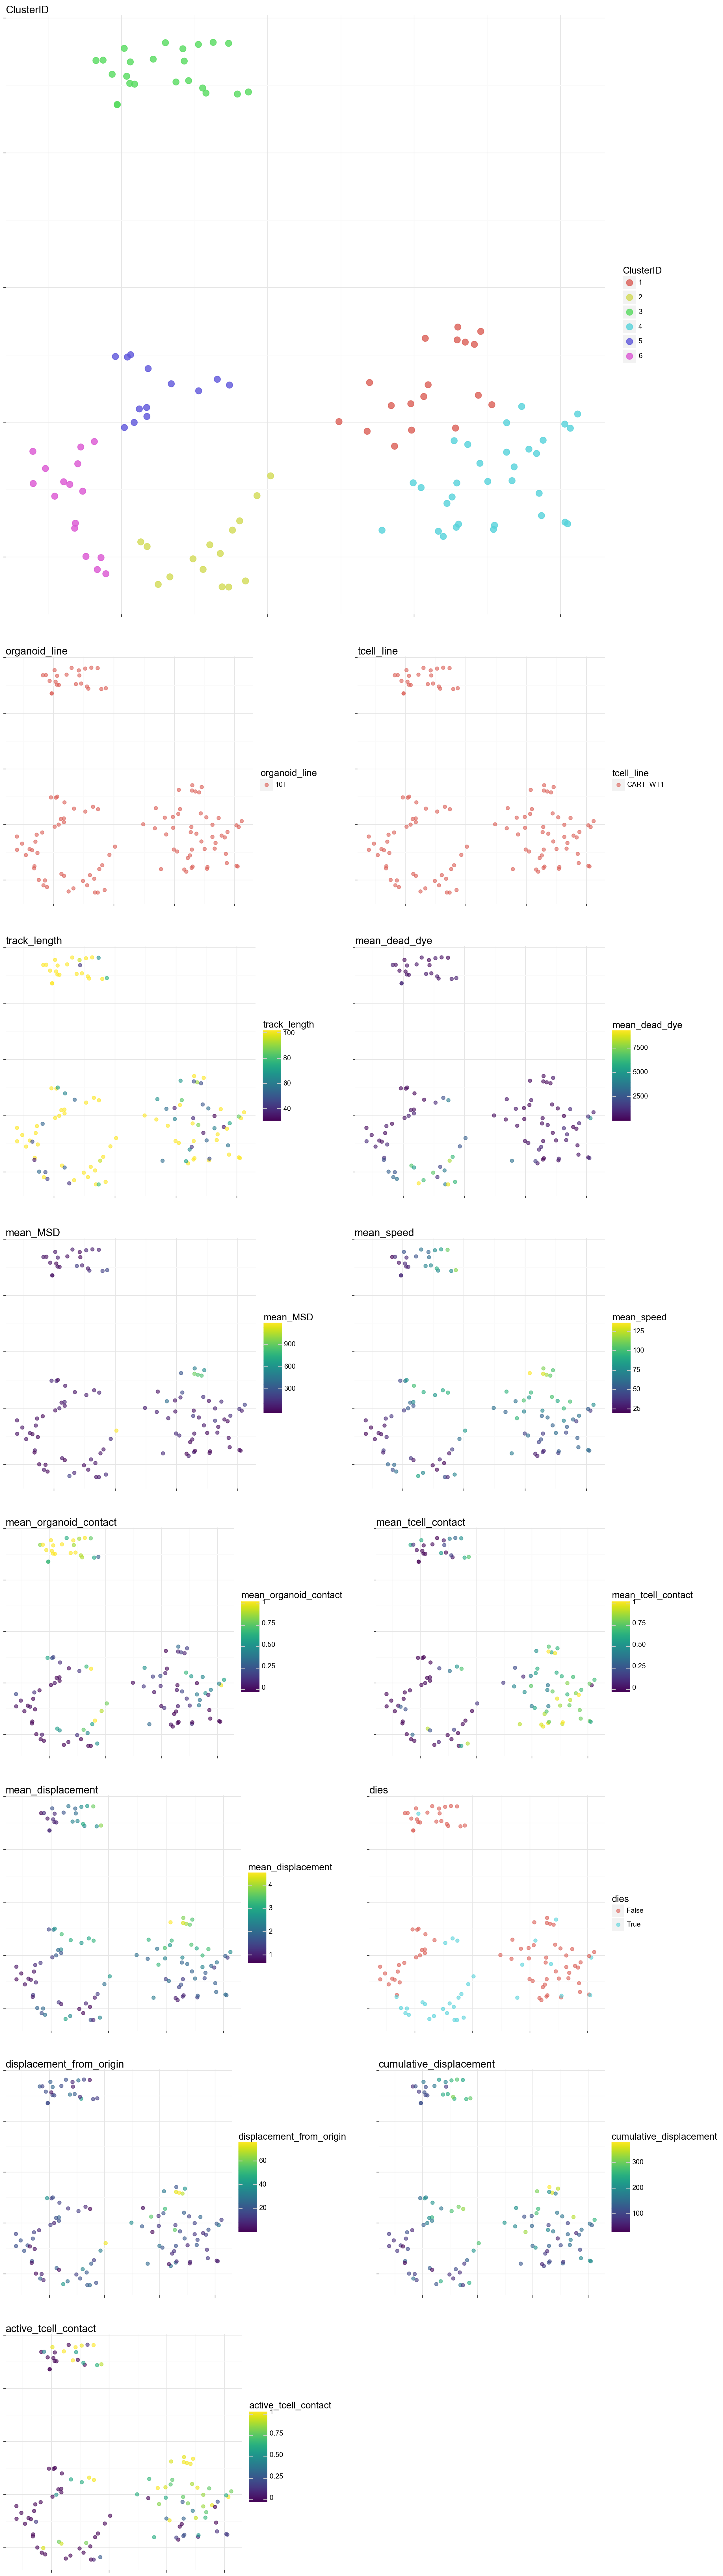

- Producing heatmaps with summarized cluster features


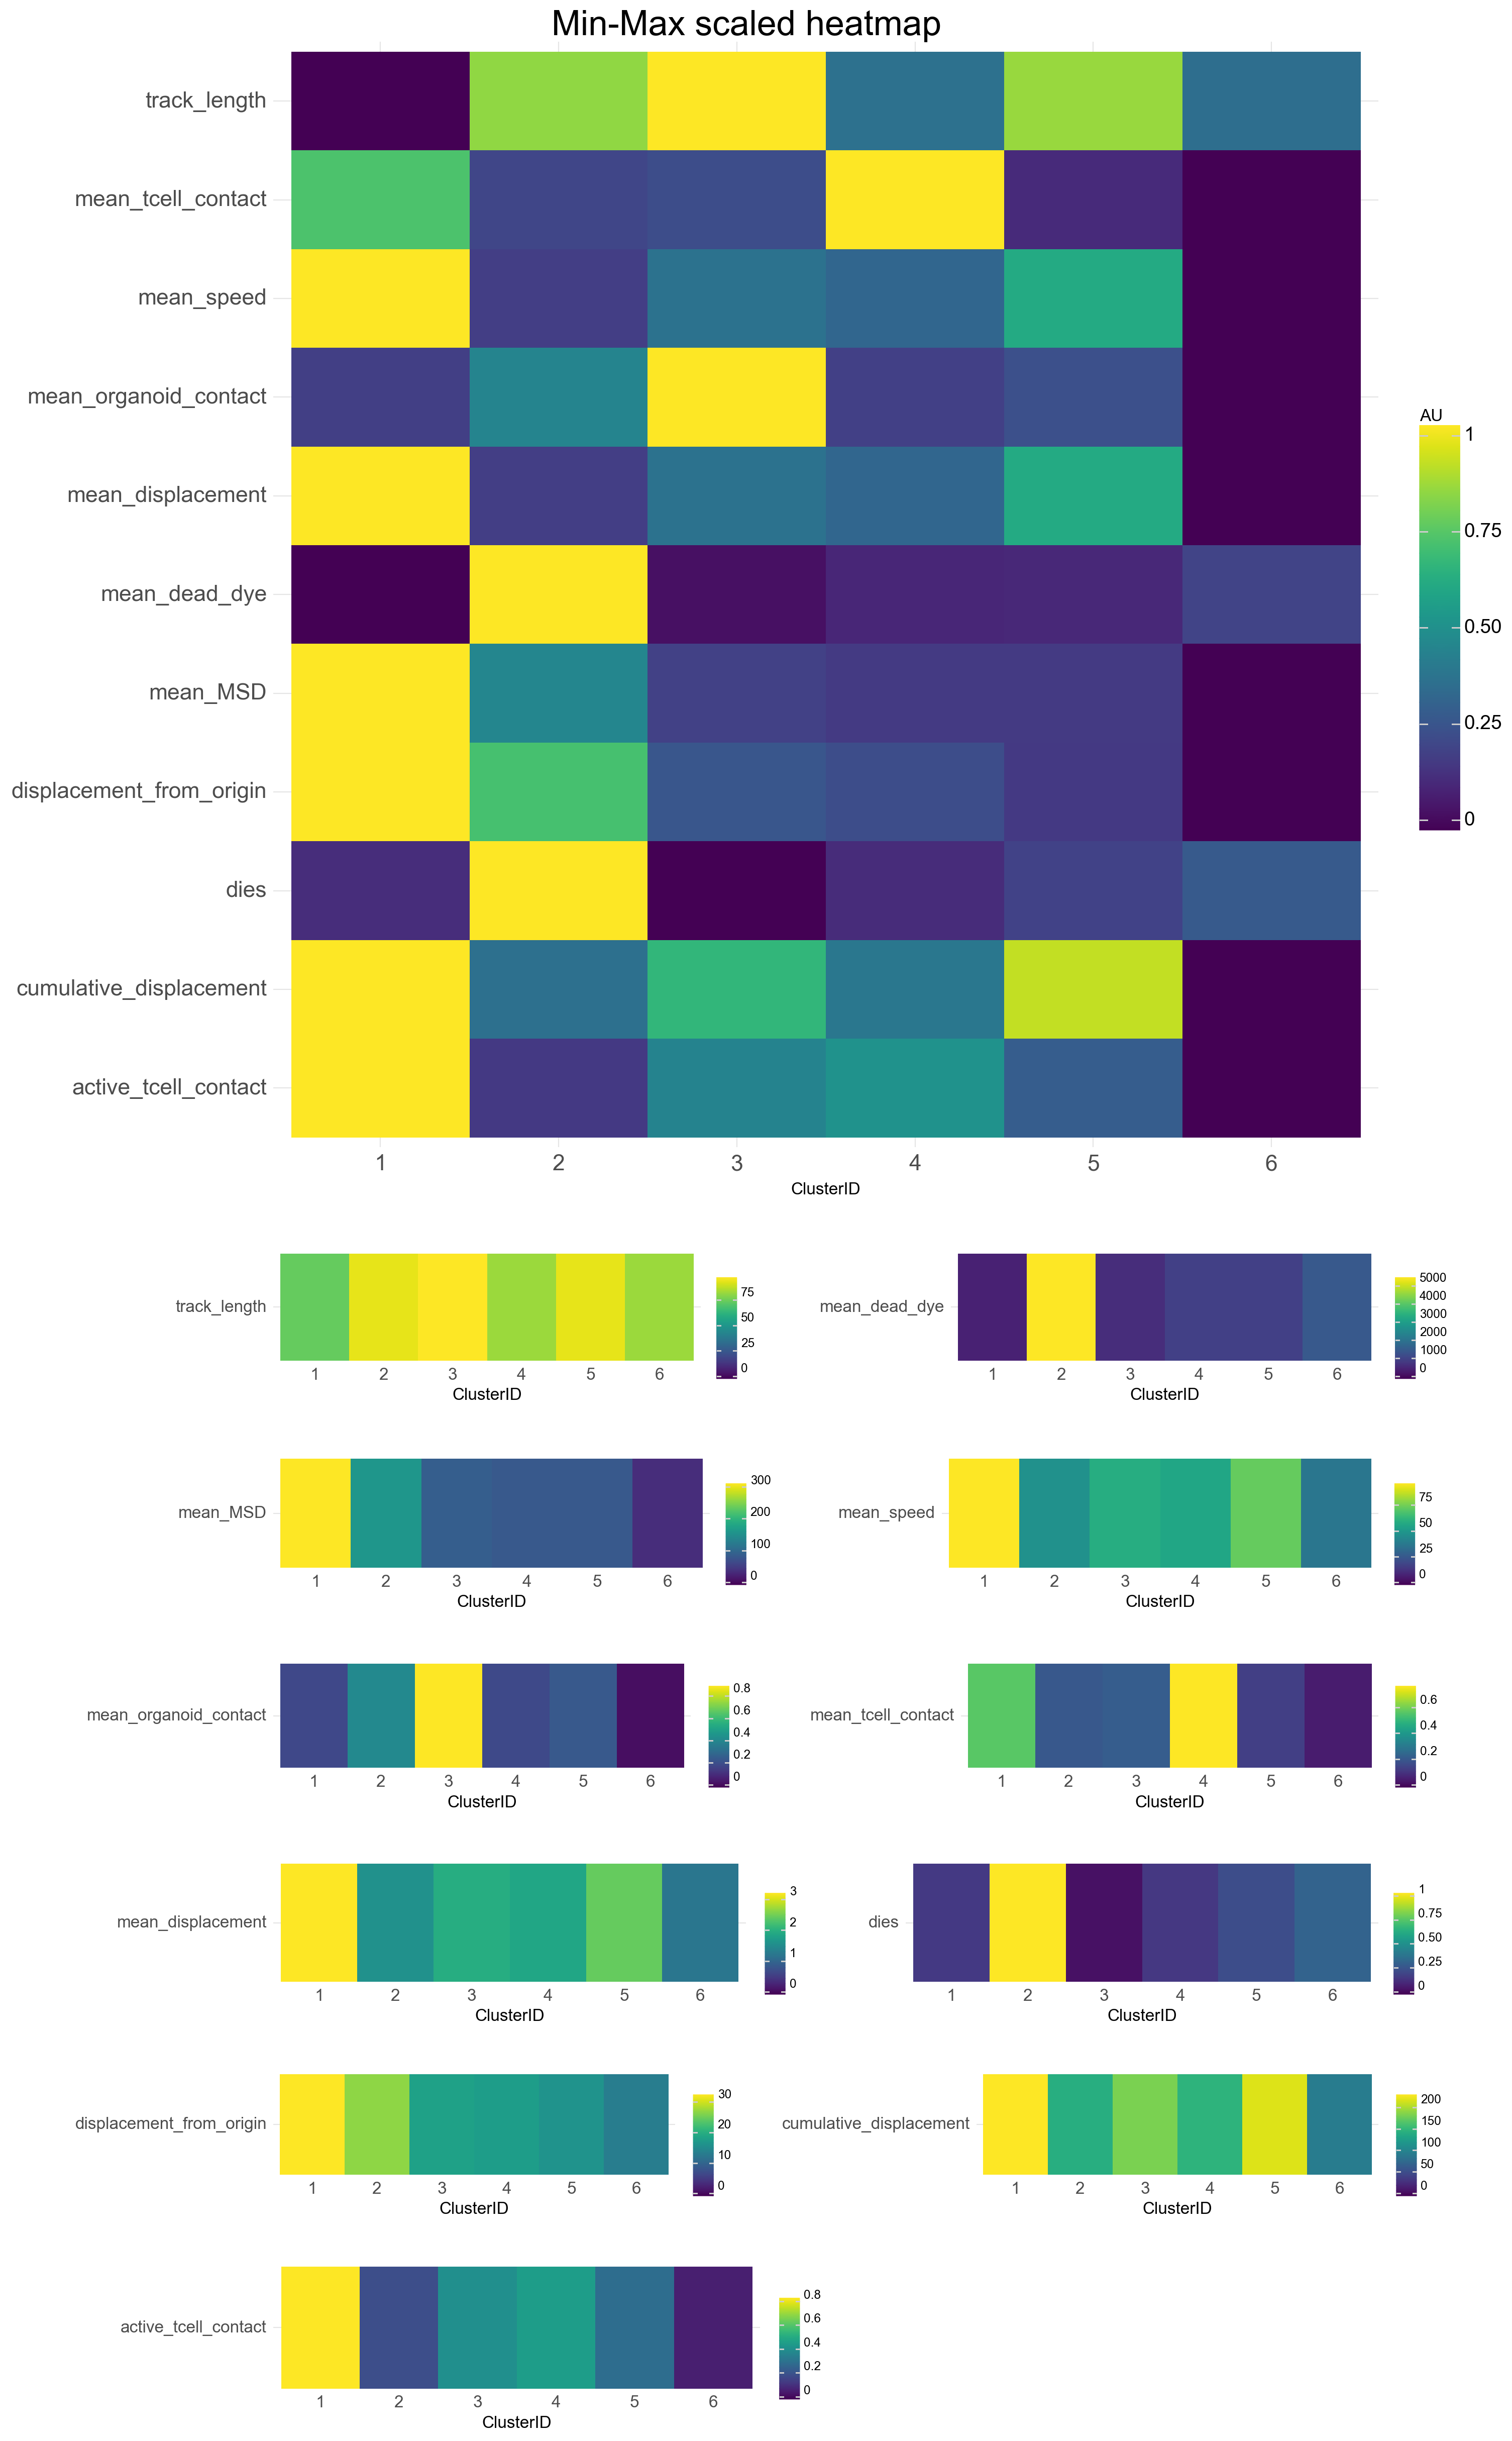

- Producing percentage plots of each cluster per combination of T-cell and organoid line


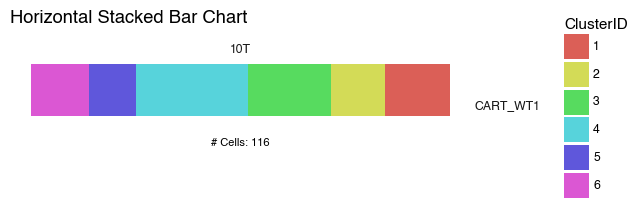

<Figure Size: (640 x 480)>

- Writing summarized tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/behav3d_output/analysis/tcells/analysis/tcells/results/BEHAV3D_UMAP_cluster_percentages.csv
### DONE - elapsed time: 0:01:03



In [5]:
df_tracks_clustered = run_tcell_analysis(
    output_dir=output_dir,
    umap_minimal_distance=umap_minimal_distance,
    umap_n_neighbors=umap_n_neighbors,
    nr_of_clusters=nr_of_clusters,
    dtw_features= dtw_features
    )

---

# Backproject results

---

**Visualize the cluster IDs and other features over the segments**
 <br>
 
*Duration: <10 minutes*


In [3]:
print("Samples in metadata .csv:")
for sample_name in metadata["sample_name"]:
    print(sample_name)

Samples in metadata .csv:
AIM_MB2_Exp58_Img003_donor899


In [3]:
sample_to_backproject="AIM_MB2_Exp58_Img003_donor899"

backprojection_data = backproject_behav3d(
    sample_name=sample_to_backproject,
    metadata=metadata,
    output_dir=output_dir,
    save=False
)

--------------- Backprojecting for AIM_MB2_Exp58_Img003_donor899 ---------------
- Loading in tracked segments
- Backprojecting all features onto each segment
Backprojecting: track_length
Backprojecting: mean_dead_dye
Backprojecting: mean_MSD
Backprojecting: mean_speed
Backprojecting: mean_organoid_contact
Backprojecting: mean_tcell_contact
Backprojecting: mean_displacement
Backprojecting: dies
Backprojecting: displacement_from_origin
Backprojecting: cumulative_displacement
Backprojecting: active_tcell_contact
Backprojecting: ClusterID
- Visualizing backprojection in napari
### DONE - elapsed time: 0:07:19



**Optionally save it as a compressed .h5**
 <br>
 
*Duration: ~40 minutes*

In [4]:
save_backprojection(
    backproj_out_path=backprojection_data["path"],
    backprojection_data = backprojection_data["data"],
    elsize = backprojection_data["elsize"]
    
)

--------------- Saving backprojection to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/behav3d_output/analysis/tcells/backprojection/AIM_MB2_Exp58_Img003_donor899_tcells_tracked_backprojected.h5 ---------------
None
### DONE - elapsed time: 0:40:15

